In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1  
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

Using TensorFlow backend.


In [2]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [3]:
def build_model(train_x,train_y,n_input,n_out):
	# define parameters
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model

	model = Sequential()
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features),return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.5))
	model.add(RepeatVector(n_outputs))
    
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')

	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 


In [4]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


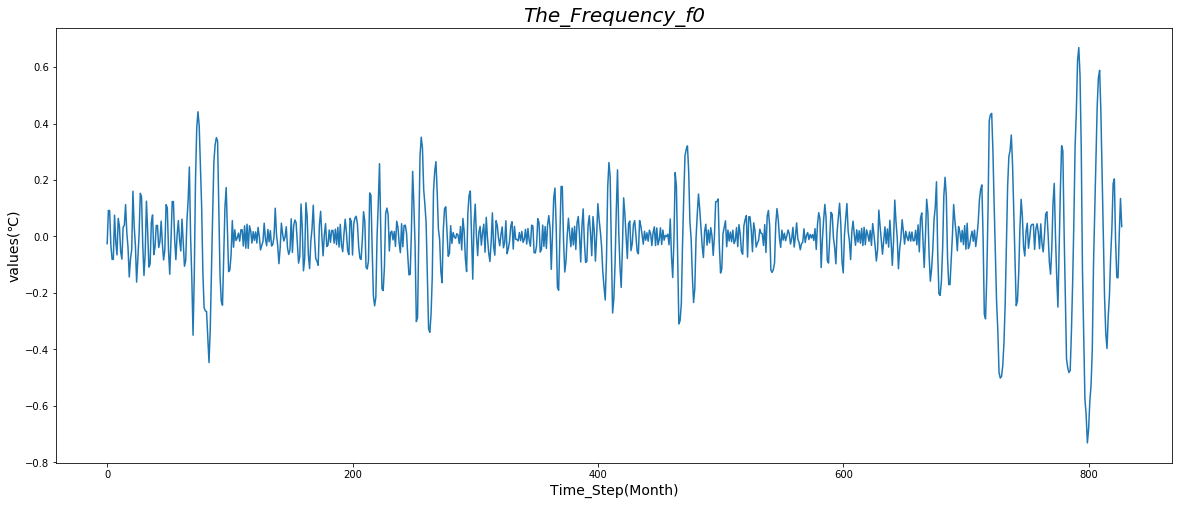

(1, 12, 1)
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(792, 12, 1)
(792, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 17s - loss: 0.0205
Epoch 2/200
 - 3s - loss: 0.0192
Epoch 3/200
 - 3s - loss: 0.0185
Epoch 4/200
 - 3s - loss: 0.0183
Epoch 5/200
 - 4s - loss: 0.0176
Epoch 6/200
 - 3s - loss: 0.0174
Epoch 7/200
 - 3s - loss: 0.0181
Epoch 8/200
 - 4s - loss: 0.0176
Epoch 9/200
 - 3s - loss: 0.0189
Epoch 10/200
 - 3s - loss: 0.0181
Epoch 11/200
 - 3s - loss: 0.0180
Epoch 12/200
 - 4s - loss: 0.0173
Epoch 13/200
 - 3s - loss: 0.0173
Epoch 14/200
 - 3s - loss: 0.0173
Epoch 15/200
 - 3s - loss: 0.0178
Epoch 16/200
 - 3s - loss: 0.0167
Epoch 17/200
 - 3s - loss: 0.0165
Epoch 18/200
 - 3s - loss: 0

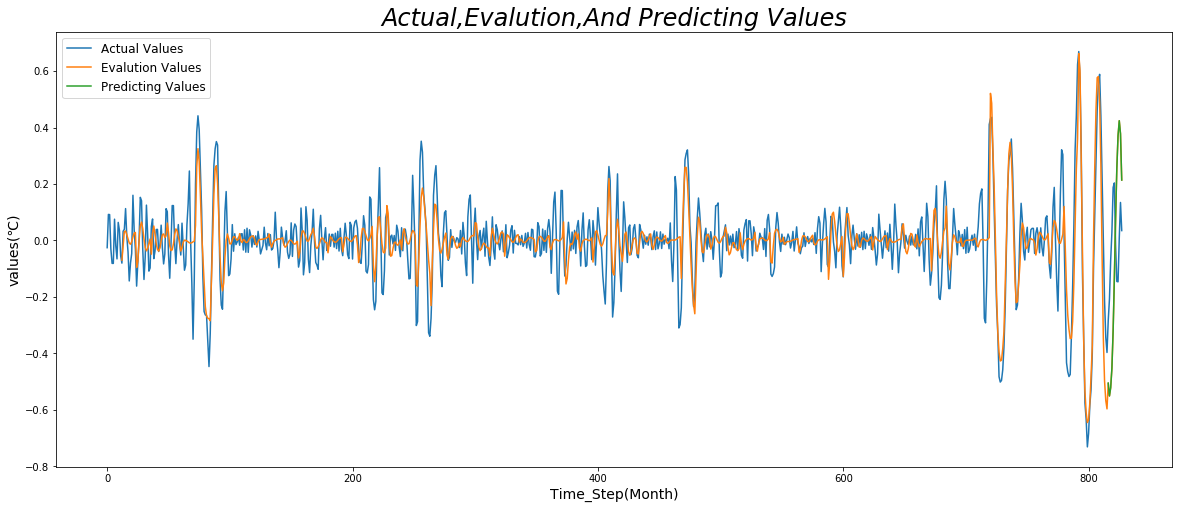

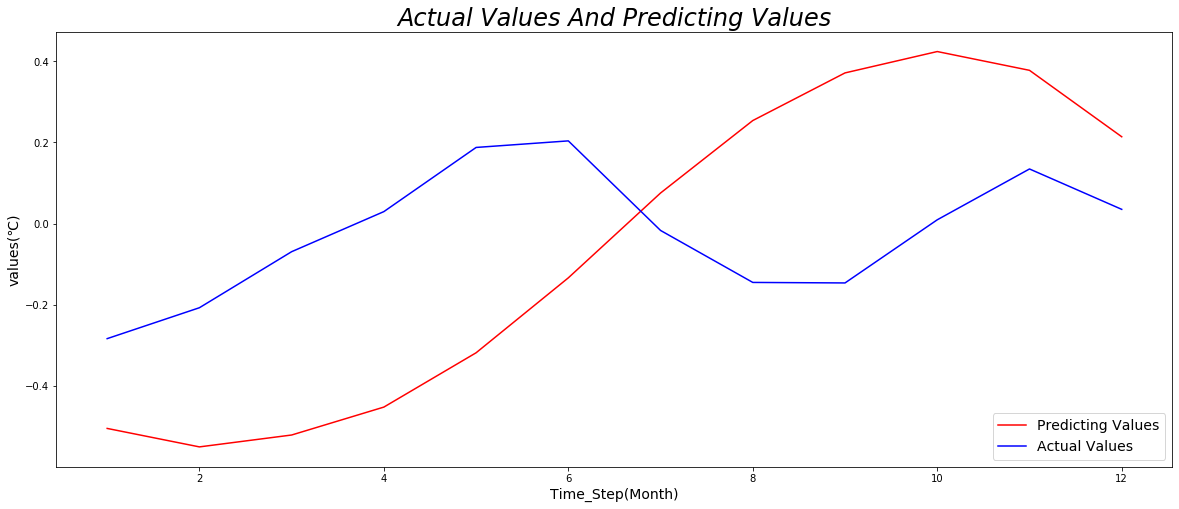

(828,)


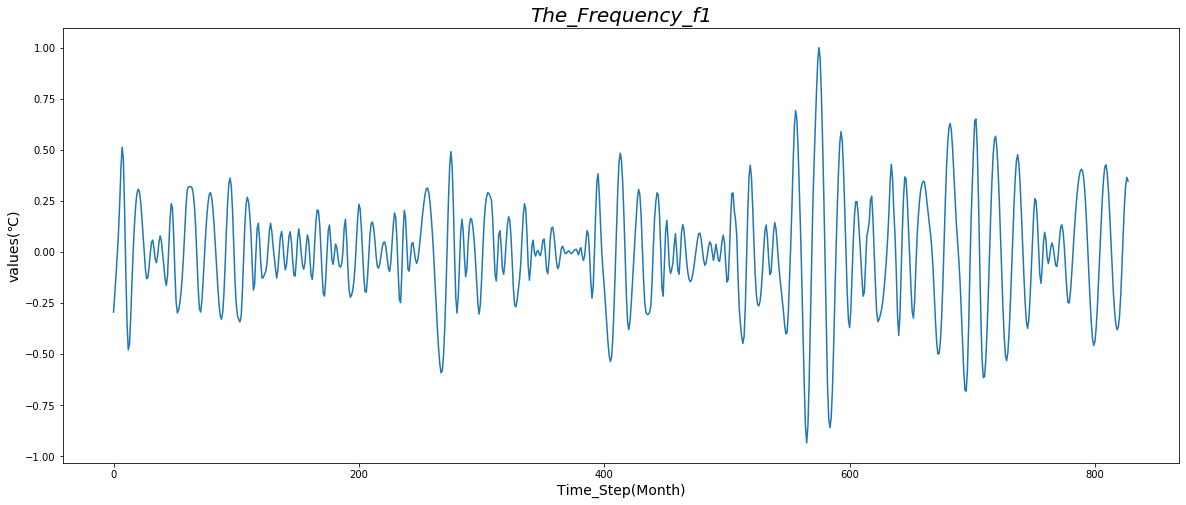

(1, 12, 1)
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.0550
Epoch 2/200
 - 3s - loss: 0.0488
Epoch 3/200
 - 3s - loss: 0.0443
Epoch 4/200
 - 3s - loss: 0.0426
Epoch 5/200
 - 3s - loss: 0.0400
Epoch 6/200
 - 3s - loss: 0.0388
Epoch 7/200
 - 3s - loss: 0.0372
Epoch 8/200
 - 3s - loss: 0.0367
Epoch 9/200
 - 3s - loss: 0.0357
Epoch 10/200
 - 3s - loss: 0.0349
Epoch 11/200
 - 3s - loss: 0.0354
Epoch 12/200
 - 3s - loss: 0.0358
Epoch 13/200
 - 3s - loss: 0.0357
Epoch 14/200
 - 3s - loss: 0.0341
Epoch 15/200
 - 3s - loss: 0.0342
Epoch 16/200
 - 3s - loss: 0.0330
Epoch 17/200
 - 3s - loss: 0.0324
Epoch 18/200
 - 3s - loss: 0.0335
Epoch 19/200
 - 3s - loss: 0.0318
Epoch 20/200
 - 3s - loss: 0.0329
Epoch 21/200
 - 3s - loss: 0.0327
Epoch 22/200
 - 3s - loss: 0.0322
Epoch 23/200
 - 3s - loss: 0.0320
Epoch 24/200
 - 3s - loss: 0.0312
Epoch 25/200
 - 3s - loss: 0.0314
E

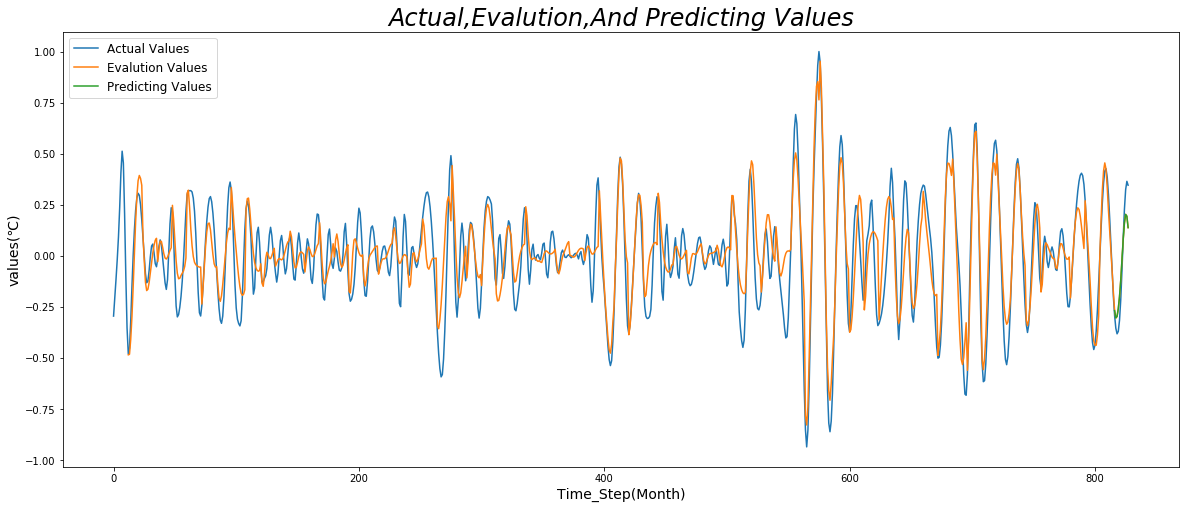

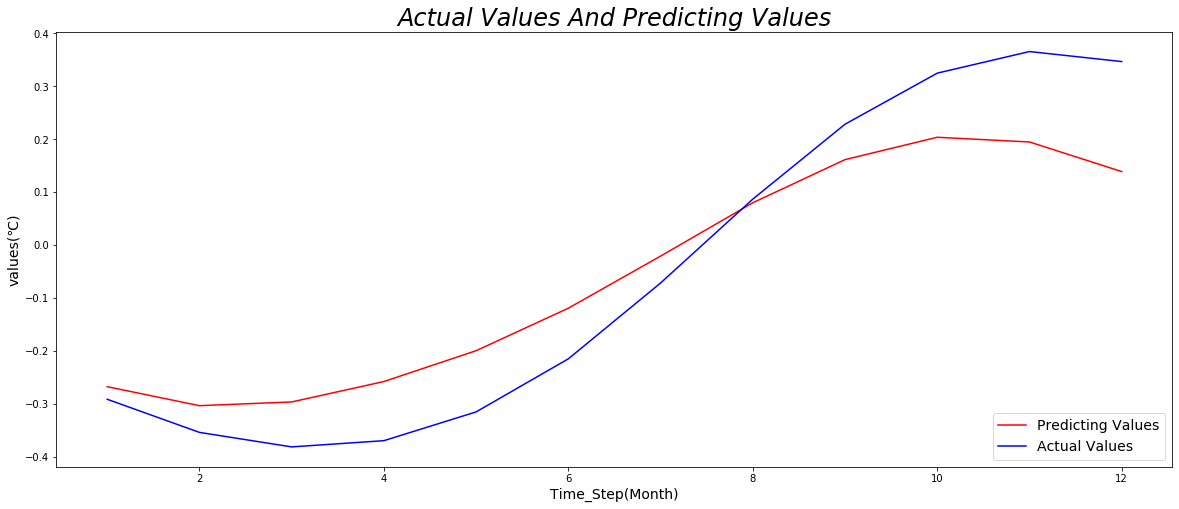

(828,)


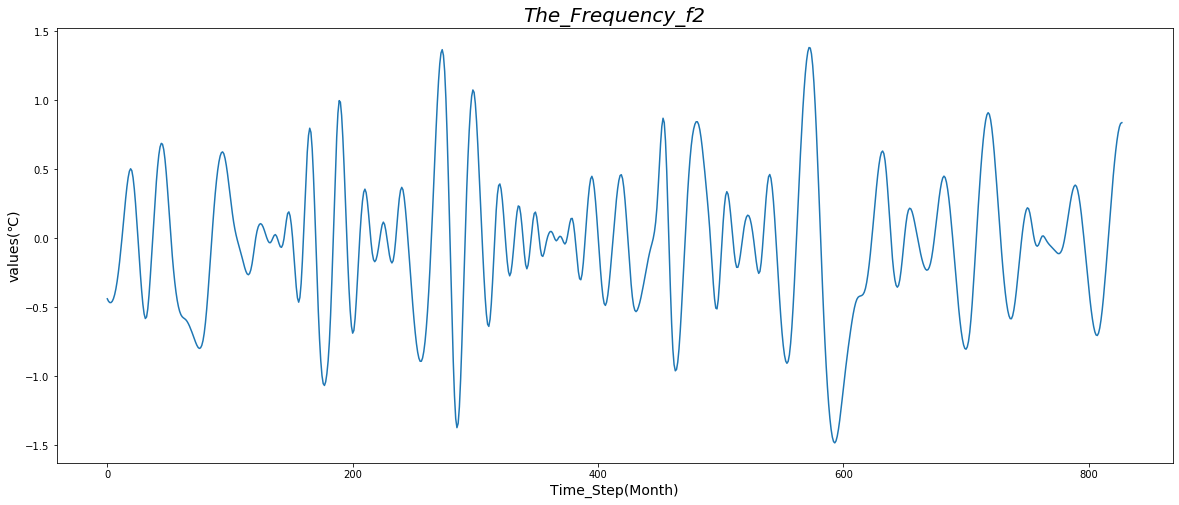

(1, 12, 1)
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.2296
Epoch 2/200
 - 3s - loss: 0.1957
Epoch 3/200
 - 4s - loss: 0.1663
Epoch 4/200
 - 4s - loss: 0.1442
Epoch 5/200
 - 3s - loss: 0.1389
Epoch 6/200
 - 3s - loss: 0.1443
Epoch 7/200
 - 3s - loss: 0.1289
Epoch 8/200
 - 3s - loss: 0.1359
Epoch 9/200
 - 3s - loss: 0.1210
Epoch 10/200
 - 3s - loss: 0.1196
Epoch 11/200
 - 3s - loss: 0.1126
Epoch 12/200
 - 3s - loss: 0.1101
Epoch 13/200
 - 3s - loss: 0.1013
Epoch 14/200
 - 3s - loss: 0.0979
Epoch 15/200
 - 3s - loss: 0.0940
Epoch 16/200
 - 3s - loss: 0.1054
Epoch 17/200
 - 4s - loss: 0.0962
Epoch 18/200
 - 3s - loss: 0.1024
Epoch 19/200
 - 3s - loss: 0.0973
Epoch 20/200
 - 4s - loss: 0.0894
Epoch 21/200
 - 4s - loss: 0.1023
Epoch 22/200
 - 3s - loss: 0.1010
Epoch 23/200
 - 3s - loss: 0.0992
Epoch 24/200
 - 3s - loss: 0.0865
Epoch 25/200
 - 3s - loss: 0.0877
Epo

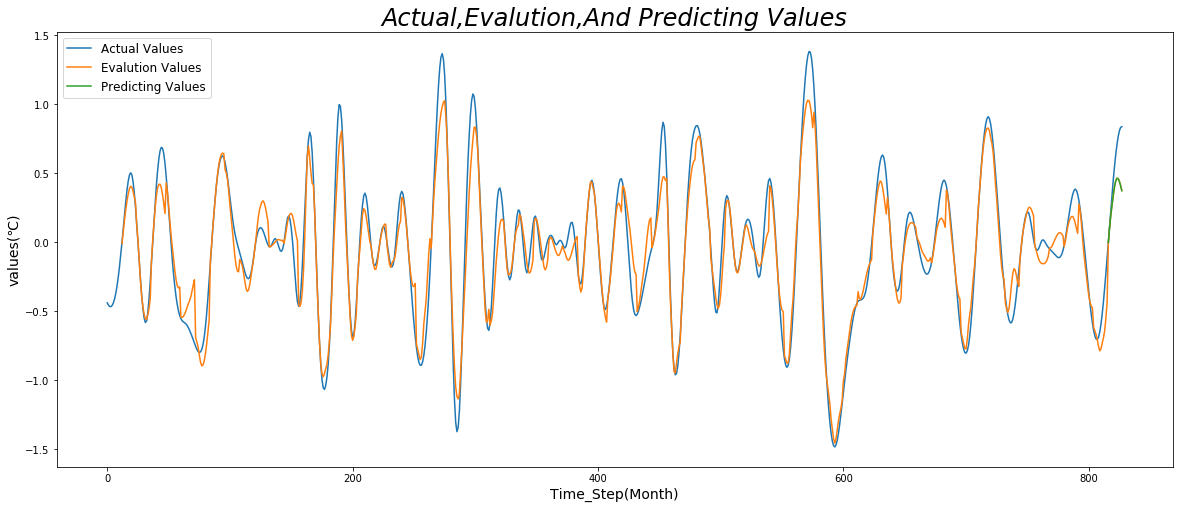

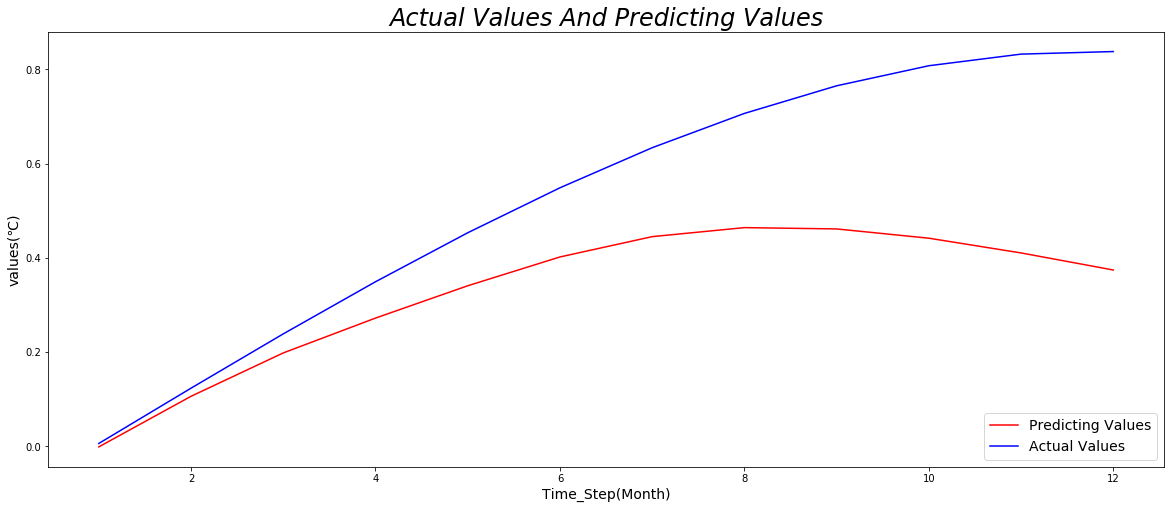

(828,)


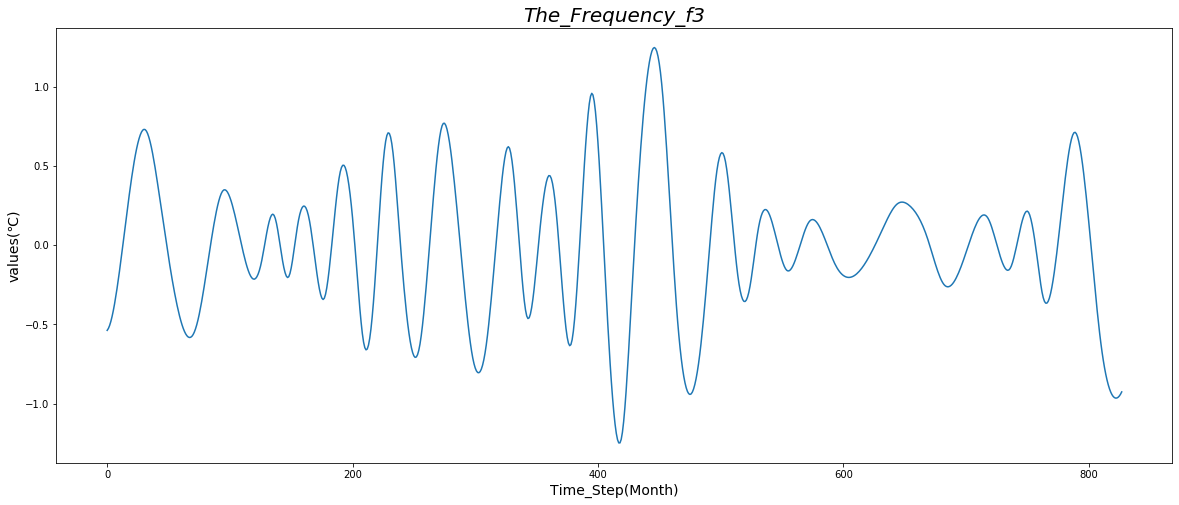

(1, 12, 1)
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.1246
Epoch 2/200
 - 3s - loss: 0.0573
Epoch 3/200
 - 3s - loss: 0.0580
Epoch 4/200
 - 4s - loss: 0.0570
Epoch 5/200
 - 3s - loss: 0.0514
Epoch 6/200
 - 3s - loss: 0.0428
Epoch 7/200
 - 3s - loss: 0.0354
Epoch 8/200
 - 4s - loss: 0.0437
Epoch 9/200
 - 4s - loss: 0.0415
Epoch 10/200
 - 3s - loss: 0.0397
Epoch 11/200
 - 3s - loss: 0.0339
Epoch 12/200
 - 3s - loss: 0.0301
Epoch 13/200
 - 4s - loss: 0.0358
Epoch 14/200
 - 3s - loss: 0.0334
Epoch 15/200
 - 3s - loss: 0.0317
Epoch 16/200
 - 3s - loss: 0.0313
Epoch 17/200
 - 3s - loss: 0.0319
Epoch 18/200
 - 3s - loss: 0.0300
Epoch 19/200
 - 3s - loss: 0.0343
Epoch 20/200
 - 3s - loss: 0.0410
Epoch 21/200
 - 4s - loss: 0.0322
Epoch 22/200
 - 3s - loss: 0.0341
Epoch 23/200
 - 3s - loss: 0.0329
Epoch 24/200
 - 3s - loss: 0.0300
Epoch 25/200
 - 3s - loss: 0.0354
Epoch 26/200


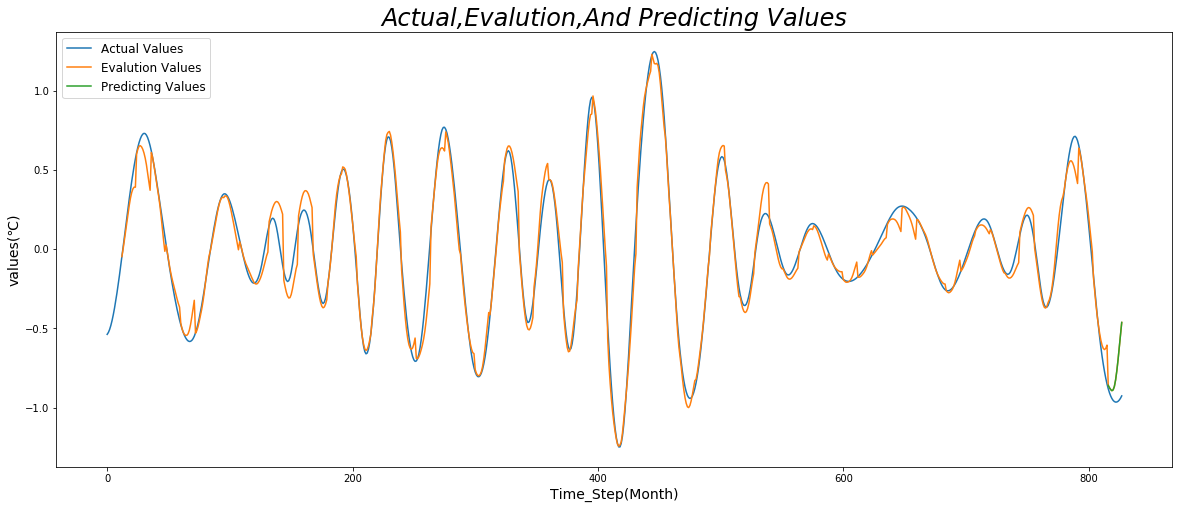

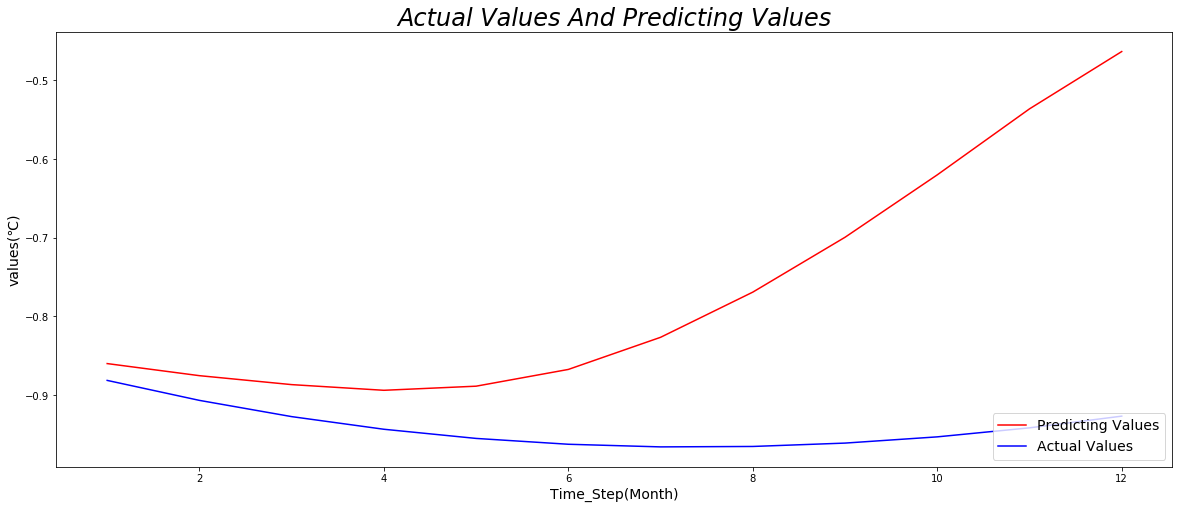

(828,)


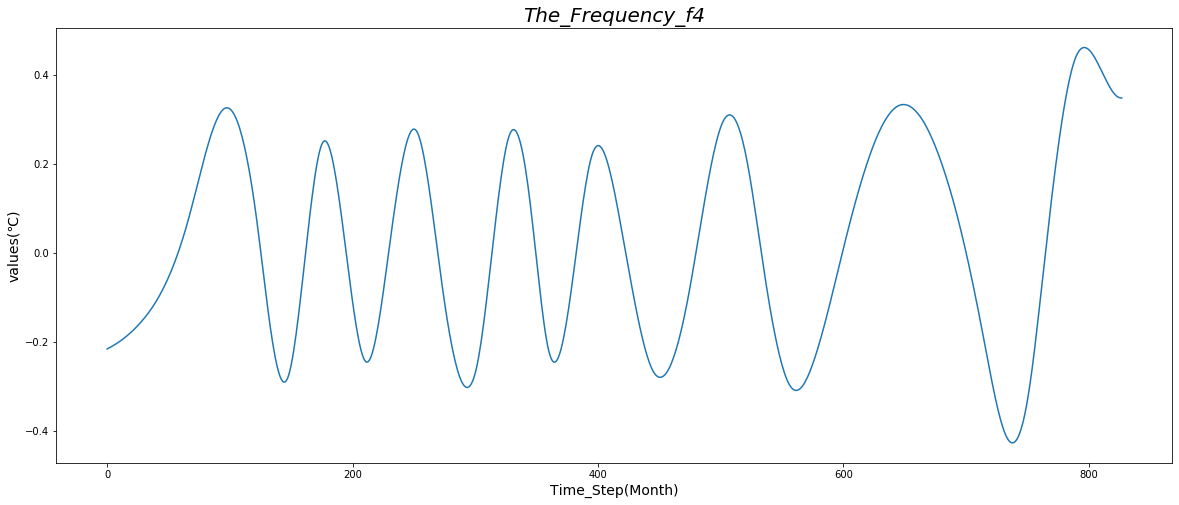

(1, 12, 1)
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 12s - loss: 0.0204
Epoch 2/200
 - 4s - loss: 0.0072
Epoch 3/200
 - 4s - loss: 0.0051
Epoch 4/200
 - 4s - loss: 0.0038
Epoch 5/200
 - 4s - loss: 0.0038
Epoch 6/200
 - 4s - loss: 0.0033
Epoch 7/200
 - 4s - loss: 0.0030
Epoch 8/200
 - 4s - loss: 0.0029
Epoch 9/200
 - 4s - loss: 0.0033
Epoch 10/200
 - 4s - loss: 0.0029
Epoch 11/200
 - 4s - loss: 0.0027
Epoch 12/200
 - 4s - loss: 0.0027
Epoch 13/200
 - 4s - loss: 0.0032
Epoch 14/200
 - 4s - loss: 0.0025
Epoch 15/200
 - 4s - loss: 0.0023
Epoch 16/200
 - 4s - loss: 0.0021
Epoch 17/200
 - 4s - loss: 0.0022
Epoch 18/200
 - 4s - loss: 0.0025
Epoch 19/200
 - 4s - loss: 0.0024
Epoch 20/200
 - 4s - loss: 0.0022
Epoch 21/200
 - 4s - loss: 0.0019
Epoch 22/200
 - 4s - loss: 0.0023
Epoch 23/200
 - 4s - loss: 0.0025
Epoch 24/200
 - 4s - loss: 0.0023
Epoch 25/200
 - 4s - loss: 0.0022
Epoch 26/200
 - 4s - loss

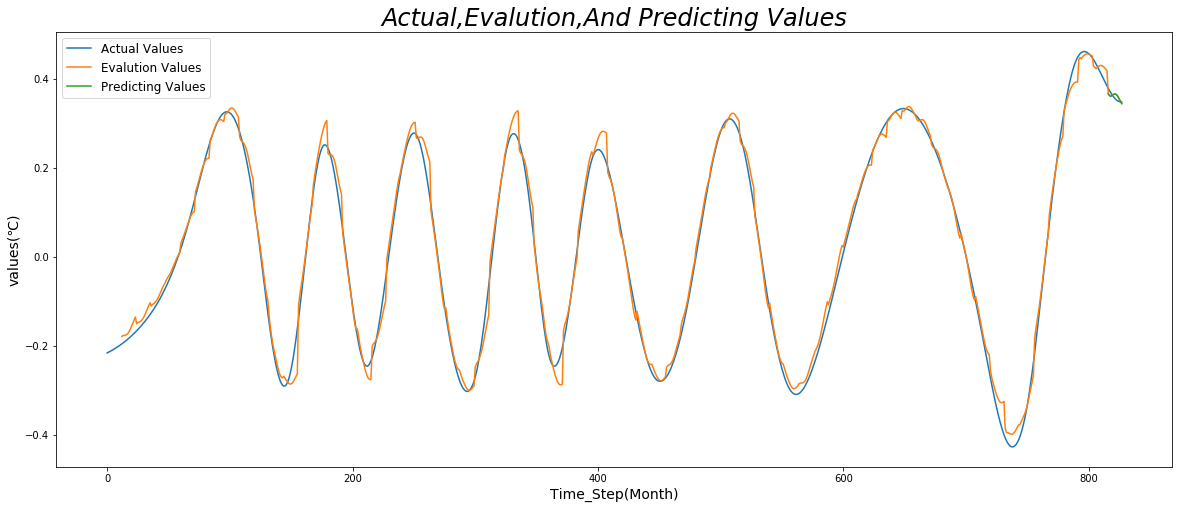

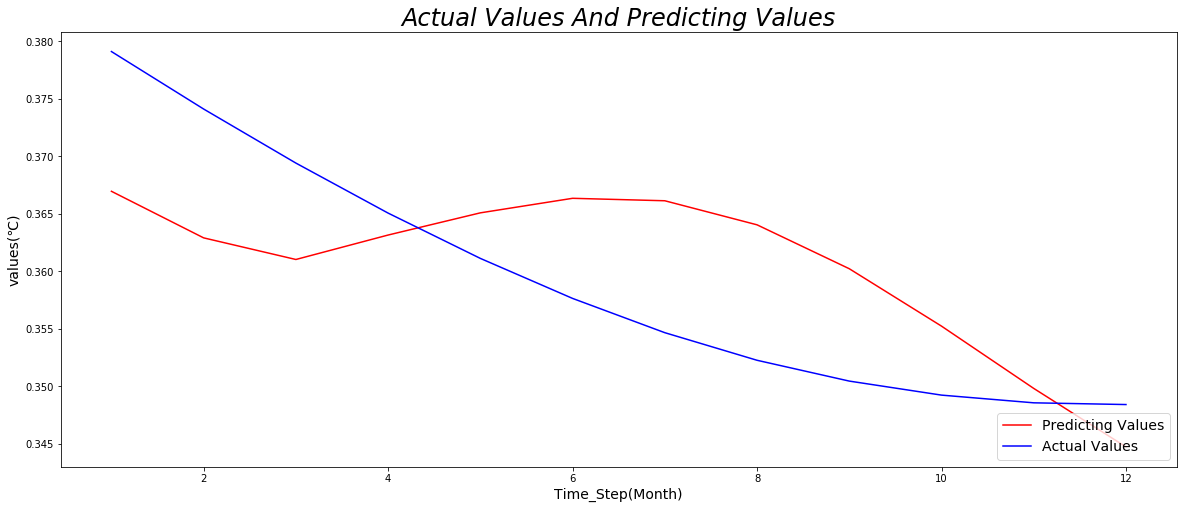

(828,)


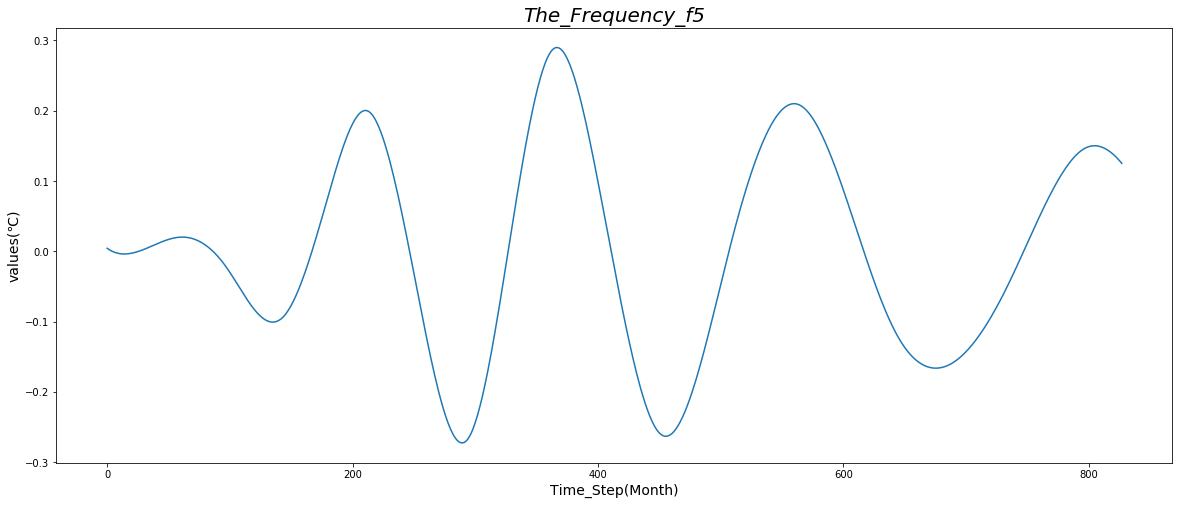

(1, 12, 1)
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 12s - loss: 0.0068
Epoch 2/200
 - 4s - loss: 0.0038
Epoch 3/200
 - 4s - loss: 0.0022
Epoch 4/200
 - 4s - loss: 0.0018
Epoch 5/200
 - 3s - loss: 0.0011
Epoch 6/200
 - 4s - loss: 8.7359e-04
Epoch 7/200
 - 4s - loss: 6.7669e-04
Epoch 8/200
 - 4s - loss: 6.0368e-04
Epoch 9/200
 - 3s - loss: 6.2776e-04
Epoch 10/200
 - 4s - loss: 7.2198e-04
Epoch 11/200
 - 4s - loss: 5.9214e-04
Epoch 12/200
 - 4s - loss: 4.5250e-04
Epoch 13/200
 - 4s - loss: 3.9015e-04
Epoch 14/200
 - 4s - loss: 4.7802e-04
Epoch 15/200
 - 3s - loss: 8.3641e-04
Epoch 16/200
 - 3s - loss: 5.9358e-04
Epoch 17/200
 - 4s - loss: 3.6992e-04
Epoch 18/200
 - 4s - loss: 4.5107e-04
Epoch 19/200
 - 3s - loss: 3.4793e-04
Epoch 20/200
 - 4s - loss: 3.1762e-04
Epoch 21/200
 - 4s - loss: 3.0579e-04
Epoch 22/200
 - 4s - loss: 3.5387e-04
Epoch 23/200
 - 4s - loss: 3.4387e-04
Epoch 24/200
 - 4s - 

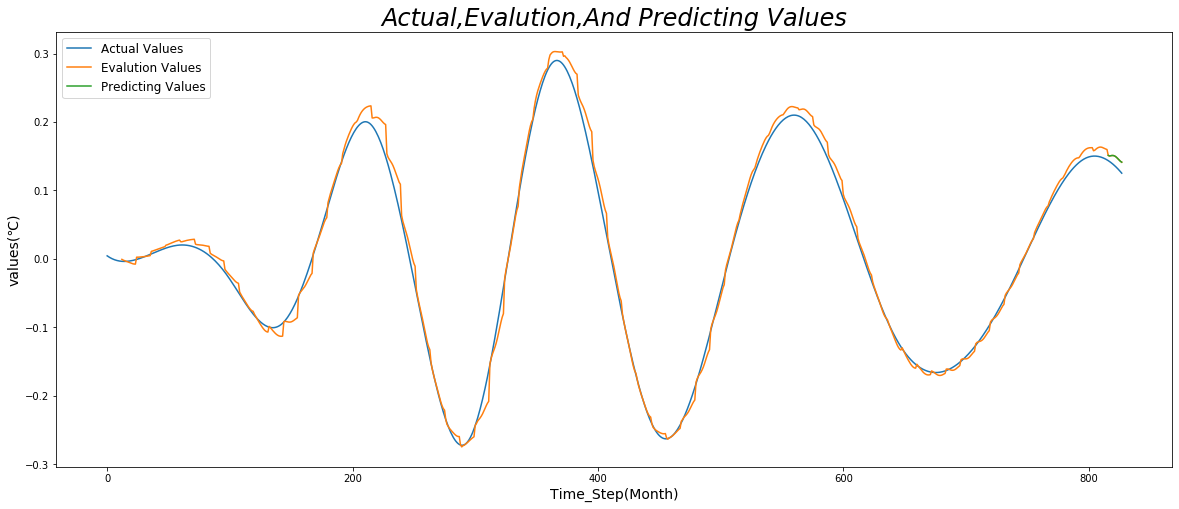

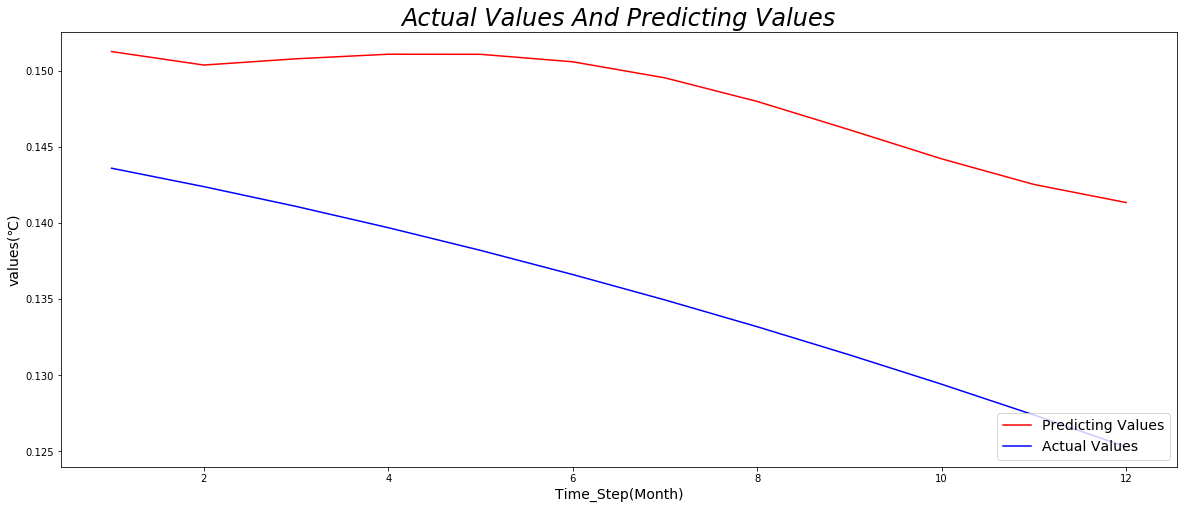

(828,)


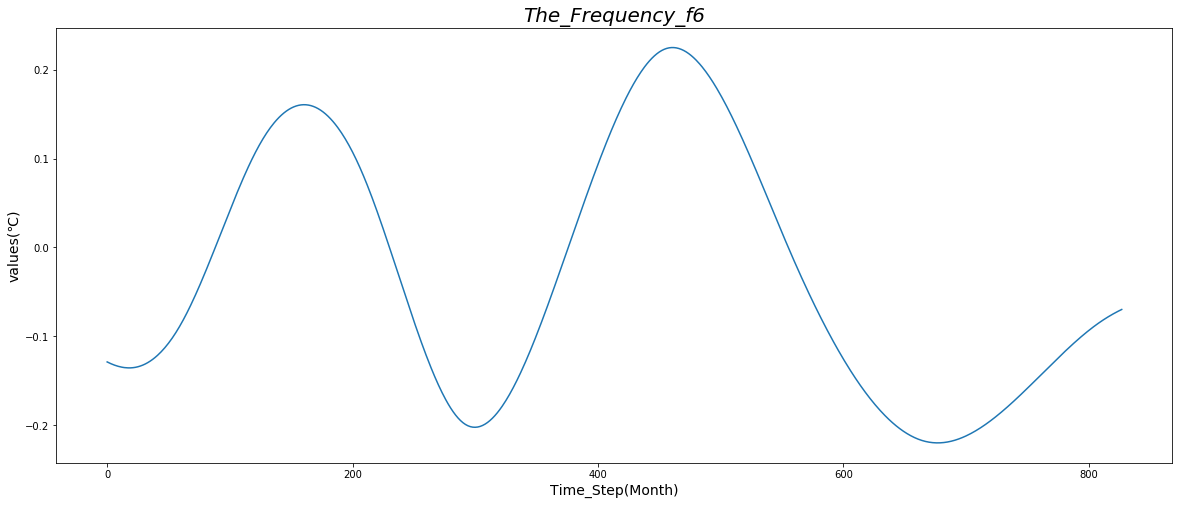

(1, 12, 1)
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 12s - loss: 0.0040
Epoch 2/200
 - 4s - loss: 0.0014
Epoch 3/200
 - 4s - loss: 0.0012
Epoch 4/200
 - 4s - loss: 0.0011
Epoch 5/200
 - 4s - loss: 9.6770e-04
Epoch 6/200
 - 4s - loss: 7.7020e-04
Epoch 7/200
 - 4s - loss: 6.8826e-04
Epoch 8/200
 - 4s - loss: 6.6788e-04
Epoch 9/200
 - 4s - loss: 5.9021e-04
Epoch 10/200
 - 4s - loss: 7.8699e-04
Epoch 11/200
 - 3s - loss: 4.6681e-04
Epoch 12/200
 - 4s - loss: 4.6530e-04
Epoch 13/200
 - 4s - loss: 3.9397e-04
Epoch 14/200
 - 4s - loss: 4.4994e-04
Epoch 15/200
 - 4s - loss: 4.0350e-04
Epoch 16/200
 - 4s - loss: 5.4652e-04
Epoch 17/200
 - 4s - loss: 4.1297e-04
Epoch 18/200
 - 4s - loss: 3.0822e-04
Epoch 19/200
 - 3s - loss: 3.2226e-04
Epoch 20/200
 - 4s - loss: 2.8147e-04
Epoch 21/200
 - 4s - loss: 2.9153e-04
Epoch 22/200
 - 4s - loss: 2.9780e-04
Epoch 23/200
 - 4s - loss: 2.87

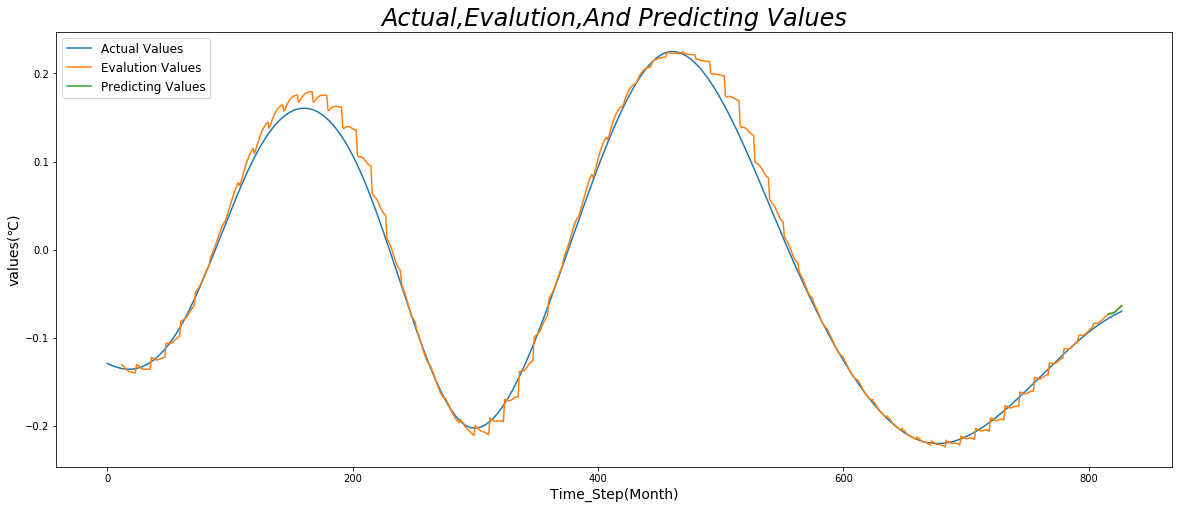

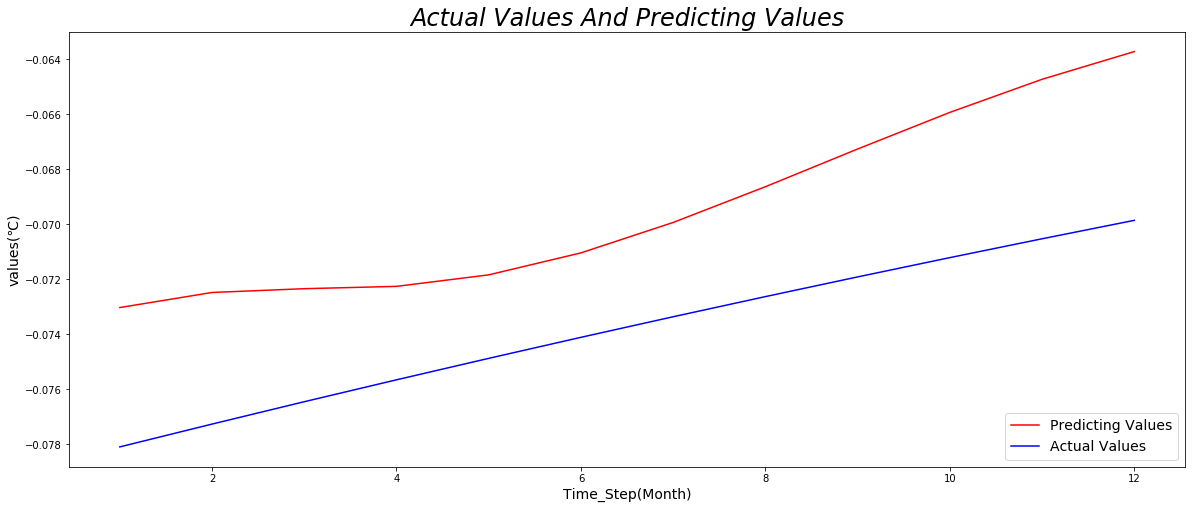

(828,)


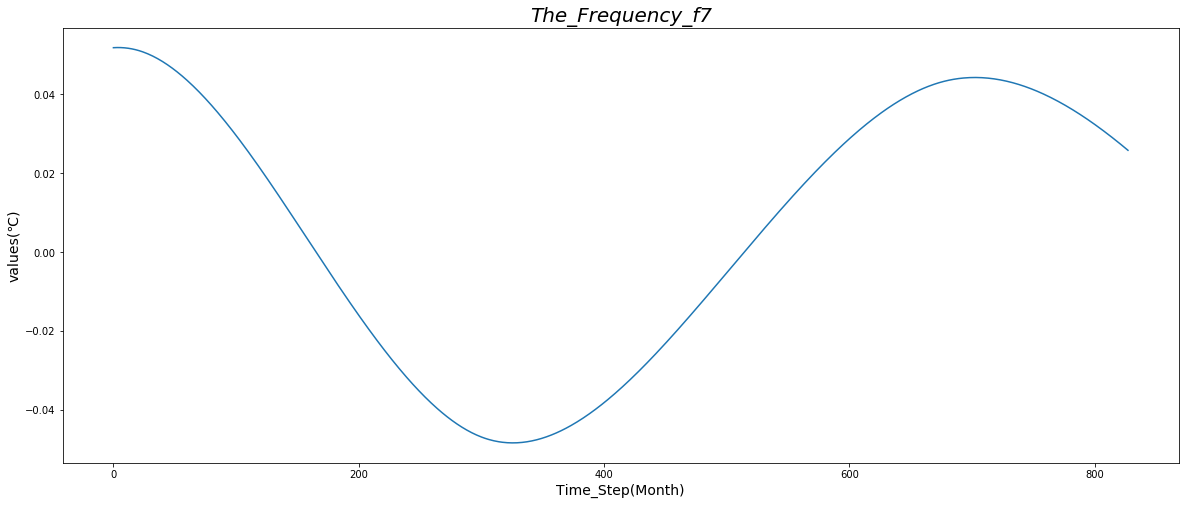

(1, 12, 1)
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 13s - loss: 3.6687e-04
Epoch 2/200
 - 4s - loss: 6.2018e-05
Epoch 3/200
 - 4s - loss: 4.2903e-05
Epoch 4/200
 - 4s - loss: 4.0022e-05
Epoch 5/200
 - 4s - loss: 3.6955e-05
Epoch 6/200
 - 4s - loss: 3.2041e-05
Epoch 7/200
 - 4s - loss: 3.0069e-05
Epoch 8/200
 - 4s - loss: 3.0845e-05
Epoch 9/200
 - 4s - loss: 2.6824e-05
Epoch 10/200
 - 3s - loss: 3.2410e-05
Epoch 11/200
 - 4s - loss: 3.1649e-05
Epoch 12/200
 - 3s - loss: 2.5773e-05
Epoch 13/200
 - 4s - loss: 2.3845e-05
Epoch 14/200
 - 4s - loss: 2.1557e-05
Epoch 15/200
 - 4s - loss: 2.4384e-05
Epoch 16/200
 - 4s - loss: 3.5979e-05
Epoch 17/200
 - 4s - loss: 2.8500e-05
Epoch 18/200
 - 4s - loss: 2.2133e-05
Epoch 19/200
 - 4s - loss: 2.9928e-05
Epoch 20/200
 - 3s - loss: 2.2684e-05
Epoch 21/200
 - 4s - loss: 2.7528e-05
Epoch 22/200
 - 4s - loss: 2.3648e-05
Epoch 23/200
 - 3s - loss: 

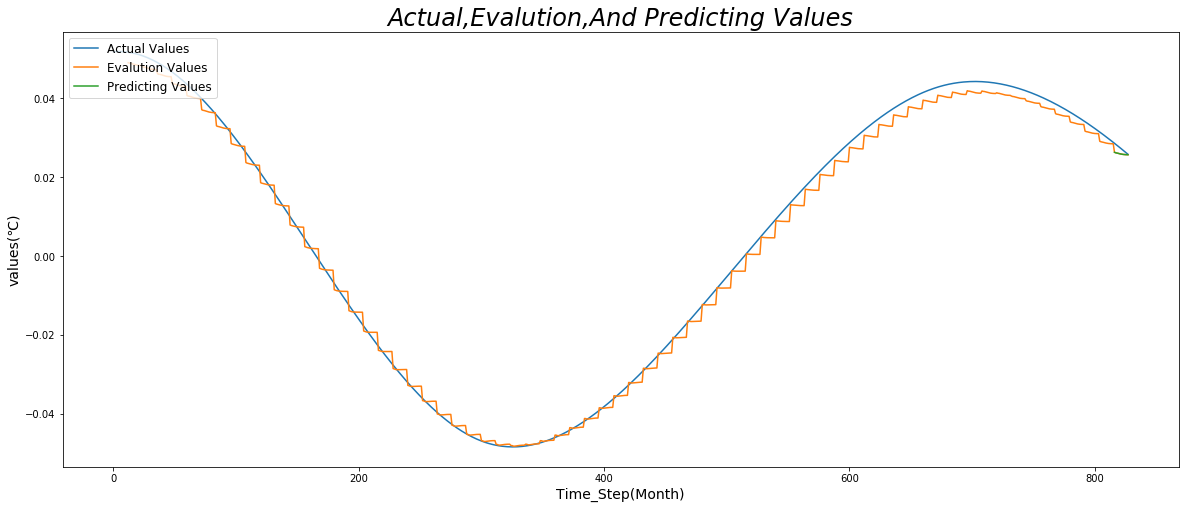

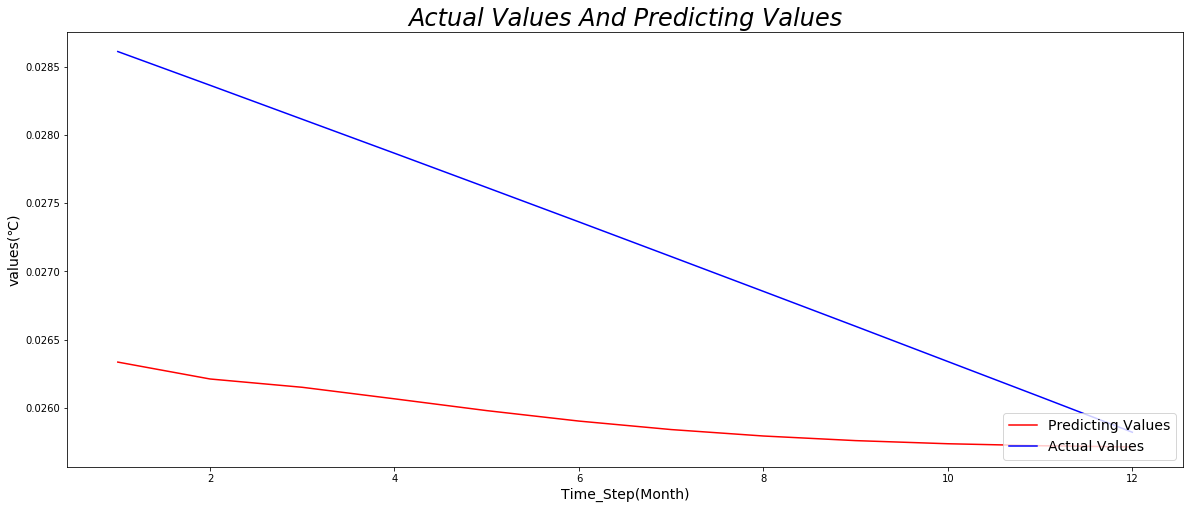

(828,)


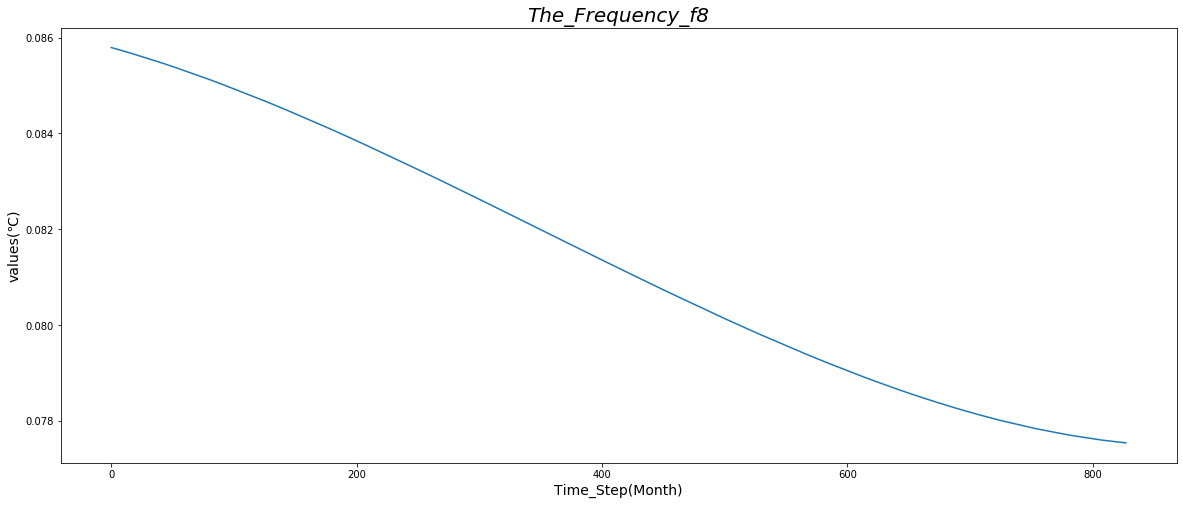

(1, 12, 1)
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 13s - loss: 5.4444e-04
Epoch 2/200
 - 4s - loss: 1.7322e-05
Epoch 3/200
 - 4s - loss: 7.8884e-06
Epoch 4/200
 - 4s - loss: 7.0283e-06
Epoch 5/200
 - 4s - loss: 6.9694e-06
Epoch 6/200
 - 4s - loss: 6.9248e-06
Epoch 7/200
 - 4s - loss: 6.6337e-06
Epoch 8/200
 - 4s - loss: 7.0297e-06
Epoch 9/200
 - 4s - loss: 6.9586e-06
Epoch 10/200
 - 4s - loss: 6.8024e-06
Epoch 11/200
 - 3s - loss: 6.8083e-06
Epoch 12/200
 - 4s - loss: 6.4571e-06
Epoch 13/200
 - 4s - loss: 6.8284e-06
Epoch 14/200
 - 4s - loss: 7.0178e-06
Epoch 15/200
 - 3s - loss: 6.2685e-06
Epoch 16/200
 - 4s - loss: 6.3044e-06
Epoch 17/200
 - 4s - loss: 6.4169e-06
Epoch 18/200
 - 4s - loss: 6.4385e-06
Epoch 19/200
 - 3s - loss: 6.2437e-06
Epoch 20/200
 - 4s - loss: 6.5452e-06
Epoch 21/200
 - 4s - loss: 6.8603e-06
Epoch 22/200
 - 3s - loss: 6.1141e-06
Epoch 23/200
 - 4s - loss: 

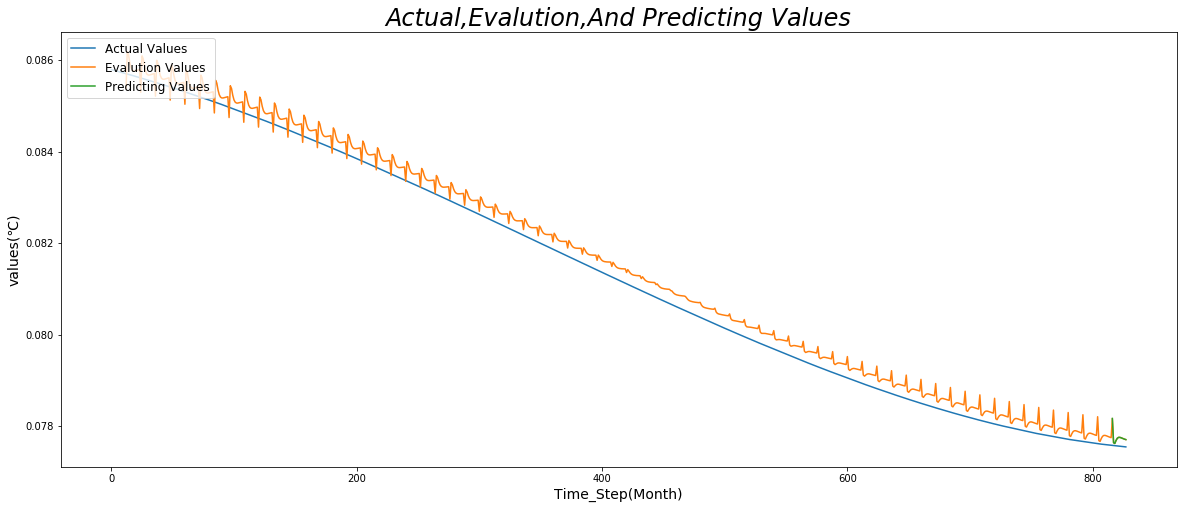

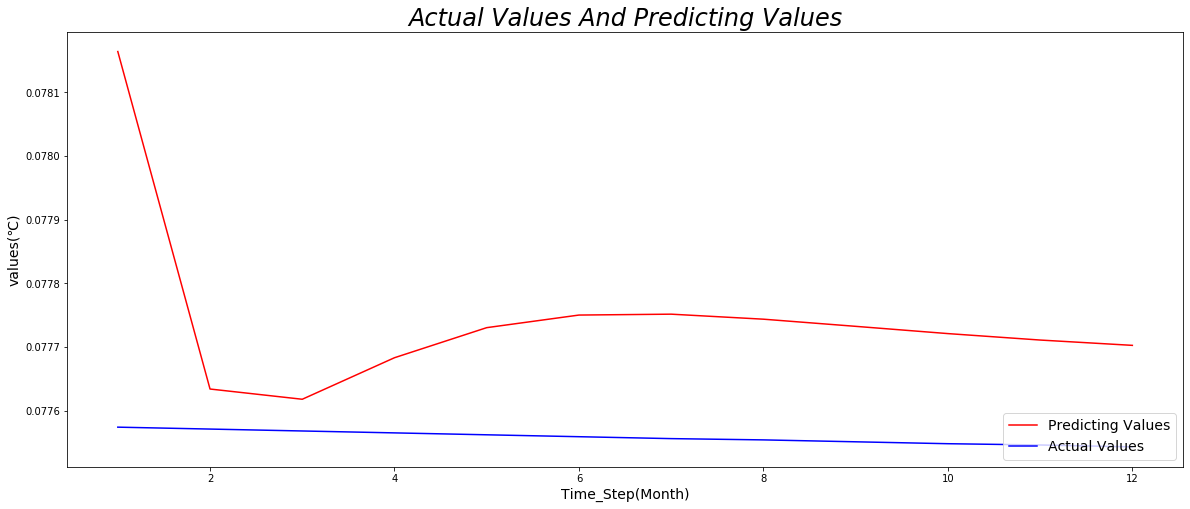

In [5]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]

signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_SoloLstm_EMD_prediction')==False):
    os.makedirs('12_months_SoloLstm_EMD_prediction')
        
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_SoloLstm_EMD_prediction/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test.shape)
    print (test[0].reshape(-1))
    
    n_input = 12
    n_out=12
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    print (train_y.shape)
    
    model=build_model(train_x,train_y,n_input,n_out)
    score, scores,predictions = evaluate_model(train, test, n_input)
    trainPredict = model.predict(train)
    print (predictions.reshape(-1))
    
    
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)

# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1)):len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [6]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07816397]
 [0.07763389]
 [0.07761782]
 [0.07768306]
 [0.07773029]
 [0.07775007]
 [0.07775147]
 [0.07774359]
 [0.07773235]
 [0.07772096]
 [0.07771083]
 [0.07770248]]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.1

In [7]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [8]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(np.array(prediction_in_one[i]).reshape(-1))) 
    predicted_values = np.add(predicted_values, np.array(prediction_in_one[i]).reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.5051056  -0.55063367 -0.52133167 -0.45248216 -0.31858358 -0.13380606
  0.07534471  0.2539855   0.37143514  0.42409822  0.3778048   0.21402209]
[-0.50510561 -0.55063367 -0.52133167 -0.45248216 -0.31858358 -0.13380606
  0.07534471  0.25398549  0.37143514  0.42409822  0.37780479  0.21402209]
the 1 frequence:
predicted_value:[-0.26765808 -0.30355537 -0.29652613 -0.25796393 -0.19973339 -0.11945327
 -0.02103535  0.07970545  0.16123436  0.20345713  0.19456448  0.13864224]
[-0.7727637  -0.85418904 -0.8178578  -0.71044609 -0.51831697 -0.25325933
  0.05430937  0.33369094  0.5326695   0.62755536  0.57236926  0.35266432]
the 2 frequence:
predicted_value:[-0.00164978  0.1058253   0.19794366  0.27192476  0.34057552  0.40176108
  0.44491845  0.4640783   0.4612924   0.44159722  0.4102925   0.37406173]
[-0.77441348 -0.74836373 -0.61991414 -0.43852133 -0.17774145  0.14850175
  0.49922782  0.79776925  0.99396189  1.06915258  0.982

[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[-1.0846407  -1.07900482 -0.9633422  -0.78667028 -0.51836445 -0.1693093
  0.22203026  0.57560947  0.83719155  0.98612001  0.97758619  0.78923514]


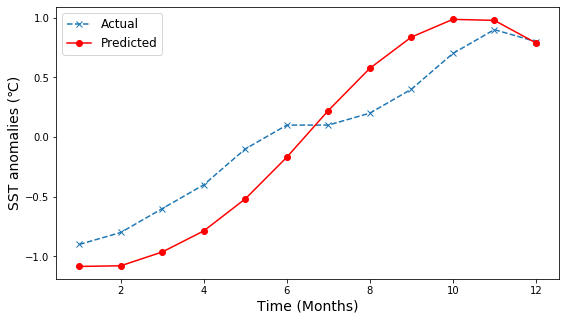

In [9]:
print (round_true_values)
print (predicted_values)

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 
 